
--------------
#### *BITTOLO* Raphaël, *TRAN-THANH* Raphaël $\\$
# <center> **MACS207b : Poisson processes** $\\$ Estimation of a Hawkes process </center>

----------------

## __Introduction__

##### **Context**


In cyber security, attacks often occur by bursts. The file

https://nextcloud.r2.enst.fr/nextcloud/index.php/s/DzfPE8Axx2H2afM

contains the dates of plenty of attacks, sorted by category and date of appearance. See the file

https://nextcloud.r2.enst.fr/nextcloud/index.php/s/xW2b6FF9ikPR8Gs

for a complete description of its content and of the motivations behind this analysis. We are going to make a simplified analysis by modeling time of attacks by a Hawkes process with intensity:

$$
\dot y(N,t)=\alpha+\beta\int_0^{t^-}e^{-\gamma(t-s)}\ \text{d} N(s)
$$

We have shown the following equality:


$$
 \log L(N,t)  =\sum_{T_{n}\le t}\log\left(\alpha+\beta\sum_{j=1}^{n-1}e^{-\gamma(T_{n}-T_{j})}\right)\
  +(1-\alpha) t-\frac{\beta}{\gamma} \sum_{T_{n}\le t} \left(1-e^{-\gamma(t-T_{n})}\right).
$$

## __Our work__

##### **Extracting "HACK" type attacks**

In [118]:
# imports
import pandas as pd
from datetime import datetime
from scipy.optimize import minimize, root_scalar
import numpy as np
import matplotlib.pylab as plt

1577       0
1578       8
1584      57
1586      60
1590      65
        ... 
5191    3257
5194    3259
5202    3263
5203    3264
8112    3265
Name: Date Made Public, Length: 1000, dtype: int64


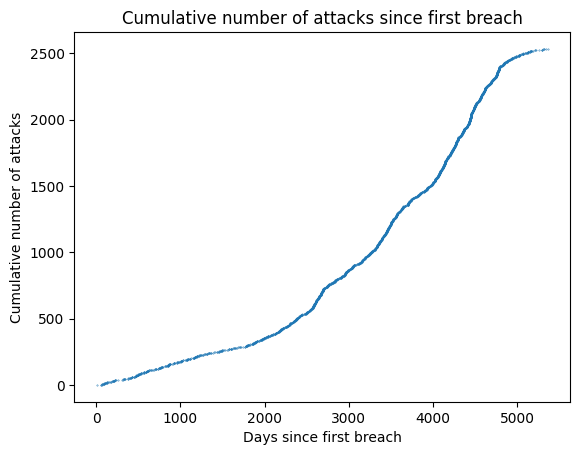

In [119]:
# opening and pre-processing the data
df=pd.read_csv("PRC.csv",sep=';')
dff=df.loc[df['Type of breach']=="HACK",'Date Made Public']
dff=dff.apply(lambda x:datetime.strptime(x,'%m/%d/%Y'))
debut=min(dff)
dff=dff-debut
dff=dff.apply(lambda x: x.days).sort_values()

# the date appears as the number of days since the first breach
print(dff.head(1000))

# plotting the data
jumps=np.asarray(dff)[1:]
plt.scatter(jumps,1+np.arange(len(jumps)),s=0.1)
plt.xlabel("Days since first breach")
plt.ylabel("Cumulative number of attacks")
plt.title("Cumulative number of attacks since first breach")
plt.show()



##### **Optimizing parameters $\alpha$, $\beta$, $\gamma$**

In [120]:
def neg_log_likelihood(params, time, eps = 1e-10):
    """
    function which returns the negative log-likelihood of the process given the parameters and the jump times
    arg:
        params: parameters of the model
        time: jump times
    return:
        negative log-likelihood (float)
    """

    # variables and parameters
    alpha, beta, gamma = params
    t = time[-1]

    # log-likelihood and integral term
    ll = 0.0
    int = 0.0
    
    # internal sum 
    for tn in time[time <= t]:
        ll += np.log(alpha + beta * int + eps)
        int += np.sum(np.exp(-gamma * (tn - time[time < tn])))
    # right-hand term
    ll += (1 - alpha) * t - (beta / gamma) * np.sum(1 - np.exp(-gamma * (t - time)))
    return -ll

def objective_function(params):
    return neg_log_likelihood(params, jumps)

# We now define the constraints 
bounds = [(0, None), (0, None), (0, 1)]
constraints = [{'type': 'ineq', 'fun': lambda x: x[1]/x[2] - x[1]}] # We need beta/gamma > 1
params0 = [0.1, 0.2, 0.1]

# Optimization 
res = minimize(objective_function, params0, bounds=bounds, constraints=constraints)

alpha, beta, gamma = res.x
print("alpha = ", alpha)
print("beta = ", beta)
print("gamma = ", gamma)   


alpha =  0.0003967362970856013
beta =  0.05683706379373829
gamma =  0.05684941195183405


##### **Computing $(y(N, T_q(N)), q \ge 1)$**

We now have an estimation of $y(N, t)$, and we know from theory that the sequence $(y(N, T_q(N)), q \ge 1)$ should follow the distribution of a Poisson process of intensity $1$. We will use a Kolmogorov-Smirnov test 

First, let's find a more convenient expression of $y(N, t)$:

$
\begin{align}
y(N, t) &= \int_0^t \dot{y}(N, x)dx \\
&= \alpha t + \beta \int_0^t \int_0^{x-} e^{-\gamma (x - s)} dN(s) dx \\
&= \alpha t + \beta \int_0^t \sum_{T_k < x^-} e^{-\gamma (x - s)}  dx \\ 
&= \alpha t + \beta \int_0^t \sum_{k} 1_{(T_k < x^-)}  e^{-\gamma (x - s)}  dx \\ 
&= \alpha t + \beta \sum_{k}  \int_0^t 1_{(T_k < x^-)}  e^{-\gamma (x - s)} dx \\ 
&= \alpha t + \beta \sum_{k}  1_{T_k < t} \int_0^t 1_{( T_k < x^- < t)}  e^{-\gamma (x - s)} dx \\ 
&= \alpha t + \beta \sum_{k}  1_{T_k < t} \frac{1}{\gamma}(1 - e^{-\gamma(t-T_k)}) \\ 
&= \alpha t + \frac{\beta}{\gamma} \sum_{T_k < t}  (1 - e^{-\gamma(t-T_k)}) \\ 
\end{align}
$

Which we can compute as follows:

In [133]:
import scipy.stats as stats

# computing y(N, t)
def y(a, b, c, t, jumps):
    S = a*t
    for k in range (np.where(jumps == t)[0][0]):
        s = 1 - np.exp(-c * (t-jumps[k]))
        S += b/c * s
    return S

# computing the sequence (y(N, T_q), q >= 1)
def yN(a, b, c, jumps):
    yN = []
    for q in range(len(jumps)):
        yN.append(y(a, b, c, jumps[q], jumps))
    return np.array(yN)


Let's check visually that the sequence $(y(N, T_q(N)), q \ge 1)$ matches the sequence $(y(P, T_q(P)), q \ge 1)$, where $P$ is a poisson process of intensity $1$.

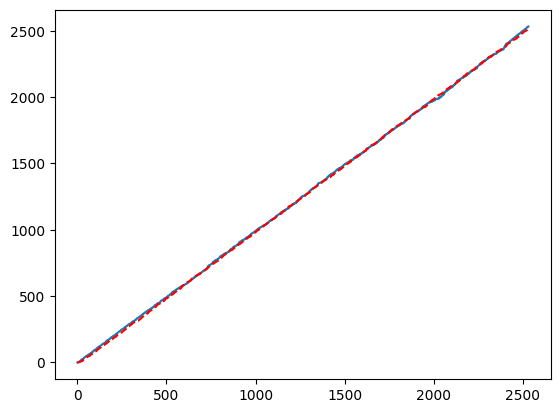

In [140]:
# plotting our estimation
plt.plot(yN(alpha, beta, gamma, jumps))

# sampling jump times of a Poisson process
jumps_poiss = np.cumsum(np.random.exponential(scale=1, size=2530))
yN_poiss = yN(alpha, beta, gamma, jumps_poiss)

# Plotting the Poisson simulation and the model
plt.plot(yN_poiss, color='red', linestyle='dashed')

plt.show()

The verification makes sense, we do observe a significantly different result with a different Poisson process:

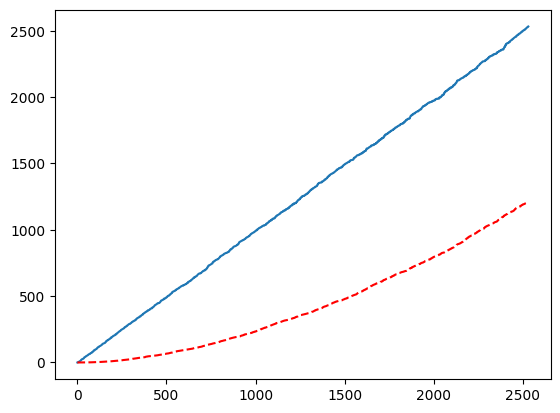

In [131]:
jumps_poiss2 = np.cumsum(np.random.exponential(scale=0.01, size=2530))

yN_poiss2 = yN(alpha, beta, gamma, jumps_poiss2)

plt.plot(yN(alpha, beta, gamma, jumps))
plt.plot(yN_poiss2, color='red', linestyle='dashed')

plt.show()




The result is also significantly different if we alter the parameters of our model, e.g. if we lower the self-excitement parameter $\gamma$

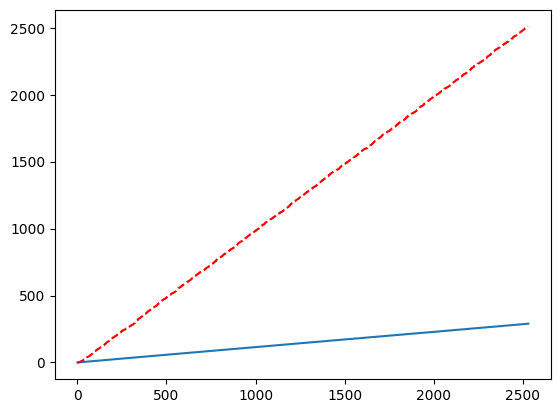

In [145]:
# plotting our estimation
plt.plot(yN(alpha, beta, 0.5, jumps))

# sampling jump times of a Poisson process
jumps_poiss = np.cumsum(np.random.exponential(scale=1, size=2530))
yN_poiss = yN(alpha, beta, gamma, jumps_poiss)

# Plotting the Poisson simulation and the model
plt.plot(yN_poiss, color='red', linestyle='dashed')

plt.show()

##### **Statistic verification**

We now verify this result statistically, using a Kolmogorov-Smirnov test:

In [135]:
# Kolmogorov-Smirnov test
ks_statistic, p_value = stats.ks_2samp(yN(alpha, beta, gamma, jumps), yN_poiss)

# Print the results
print(f"KS Statistic: {ks_statistic}")
print(f"P-Value: {p_value}")

KS Statistic: 0.012288556281962423
P-Value: 0.9893046175523414


The result is verified with a good K-S statistic and p-value. We have indeed a Poisson process of parameter $1$ !